# Pima Native Americans and Type II Diabetes
## My First Machine Learning Project

In this analysis, I utilize various classifaction supervised machine learning algorithms for determining whether a patient has type II diabetes certain criterion given. I utilize methods for cross-validation of supervised classification models. This is a pretty lengthy notebook, but features many concepts and topics. I found my experience to be quite rewarding regarding educational purposes. 

Sidenote: This is my first time using machine learning so I would appreciate feedback.



## About the Data:

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. 
All patients here are females at least 21 years old of Pima Indian heritage.
The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. 
Challenge via kaggle: https://www.kaggle.com/uciml/pima-indians-diabetes-database



# 1. Pre-Processing and Data Exploration 

Goal: predict whether or not a patient has diabetes accurately (1 : has type II diabetes, 0 : no diabetes).

Time to import all necessary packages (this is usually a working list other than some standards).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
import math
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from collections import Counter
import os
#import warnings
#warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Initial Observations and Preprocessing

Data is in csv so it is already usable; not much wrangling required. Now we will have a dataframe data type of the data.

In [2]:
file_path="C:/Users/Blob2/Desktop/Projects/data_files/diabetes.csv"
raw_diabetes = pd.read_csv(file_path)

Let's peruse a peek at the data with head() and then check out the first patient.

In [71]:
raw_diabetes.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [72]:
raw_diabetes.iloc[0]

Pregnancies                   6.000
Glucose                     148.000
BloodPressure                72.000
SkinThickness                35.000
Insulin                       0.000
BMI                          33.600
DiabetesPedigreeFunction      0.627
Age                          50.000
Outcome                       1.000
Name: 0, dtype: float64

##### How many patients do we have?

In [73]:
raw_diabetes.shape

(768, 9)

In [74]:
x = 798*9
x

7182

Okay, so there are 9 variables, 1 of which is the outcome.
There are 768 patients and 7182 values (7182 - 768 exlcuding the outcome column).

#### Describe and quickly visualize the data a little to see means and spreads.

In [75]:
raw_diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x720 with 0 Axes>

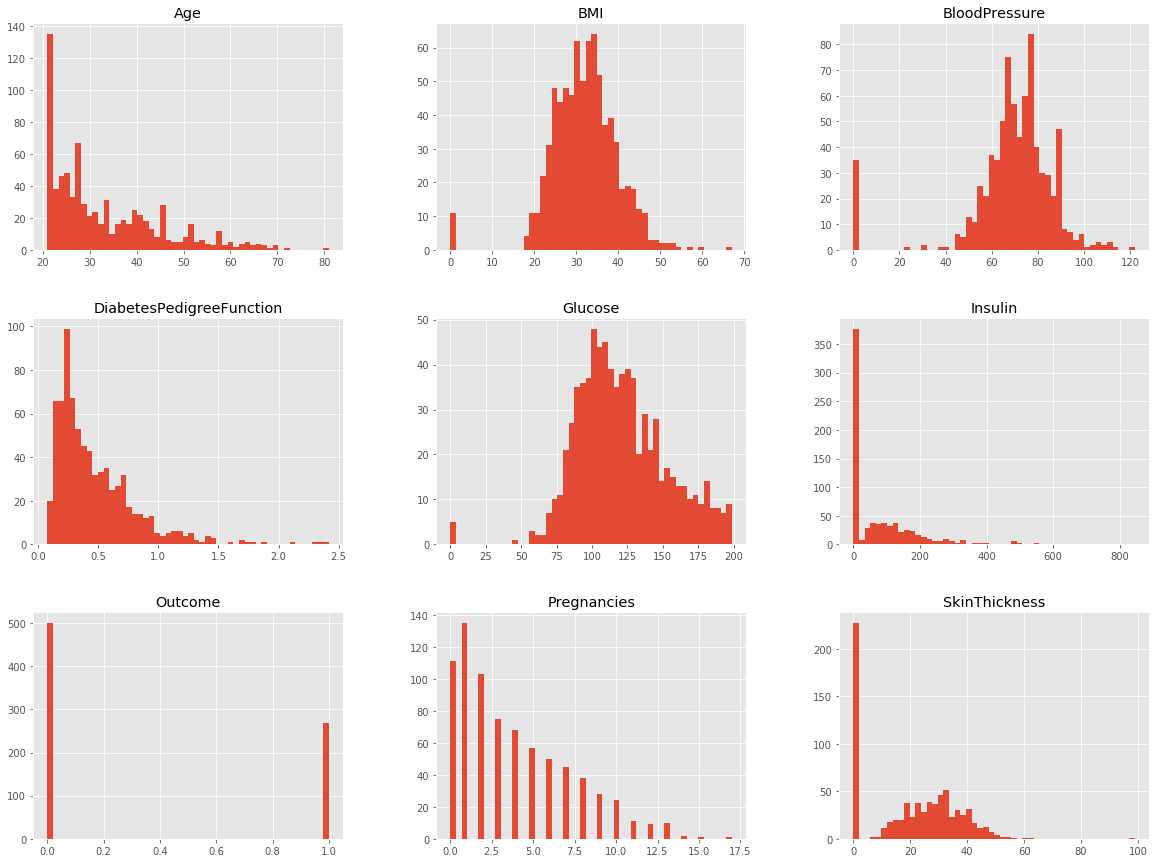

In [76]:
#very high deviations :(  Bad data? Probably
#Lets visualize the raw data slightly
#see the spreads

plt.figure(figsize=(6,10))

raw_diabetes.hist(bins=50, figsize=(20, 15))
plt.show

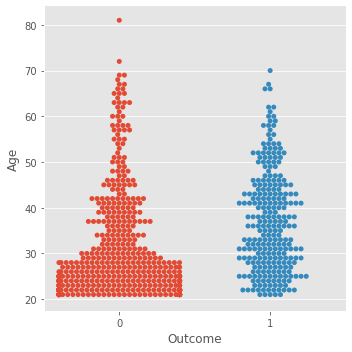

In [77]:
sns.catplot(kind="swarm", data=raw_diabetes, x="Outcome", y="Age")

## We learned a few things from initial peruse.

### 1) There are double the amount of non-diabetic patients in the dataset so most predictions of algorithms will be skewed towards not having diabetes. Essentially false negatives will probably be a problem. 


### 2) We need to correct some of the zero values.

Some of the patients cannot physically have zero values for catergories. For example, Skin Thickness is 0, which makes absolutely no sense unless this is data from unfathomably tortured people.

Let's impute values for the following columns where zero doesn't make any sense and should be treated as missing values: Glucose, BloodPressure, SkinThickness, Insulin, BMI.

I'm doing imputation before even spliting the data because if there were missing values in a new patient, then those values would be pre-processed too before entering the model.

A zero value would throw off the prediction in a skewed direction because of the heavy clustering on zero.

#### Change those zero values to Nan.

In [3]:
original_data = raw_diabetes #just in case

labels_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for i in labels_with_zeros:
    raw_diabetes.loc[raw_diabetes[i] == 0, i] = math.nan

In [79]:
raw_diabetes.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8,125.0,96.0,NaN,NaN,NaN,0.232,54,1


## Now we go from Nan to imputated values.

There is actually a choice here not to impute values because it actually tampers with the data. It is no longer 'pristine' or raw. There are algorithms where the orignal data can be used like Random Forest.

If I were to use a 
##### Multiple Imputations by Chains Equations (MICE) method 
to fill in the data, I would do this:
______________________________________________________

mice_imputer = IterativeImputer()

filled_nans = mice_imputer.fit_transform(raw_diabetes)

raw_diabetes.iloc(:,:) = filled_nans

_______________________________________________________________________

### But I'm not.
Using MICE would assume that the missing data is at random and not in any pattern. We are trying to see if there is a pattern already, not randomize it. Instead we are using: 
#### k-Nearest Neighbors imputation
to preserve dependencies and/or patterns.

In [4]:
knn_imputer = KNNImputer(n_neighbors=3)
imputed_data = knn_imputer.fit_transform(raw_diabetes)
len(imputed_data[:,0])

768

In [5]:
raw_diabetes.iloc[:,:] = imputed_data
raw_diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.000000,3.0000,6.00000,17.00
Glucose,768.0,121.563368,30.550074,44.000,99.000000,117.0000,141.00000,199.00
BloodPressure,768.0,72.342448,12.221390,24.000,64.000000,72.0000,80.00000,122.00
SkinThickness,768.0,29.099392,9.580304,7.000,22.333333,29.0000,35.00000,99.00
Insulin,768.0,153.414063,100.846193,14.000,83.000000,132.0000,191.00000,846.00
BMI,768.0,32.426259,6.889295,18.200,27.500000,32.1500,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.243750,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.000000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.000000,0.0000,1.00000,1.00


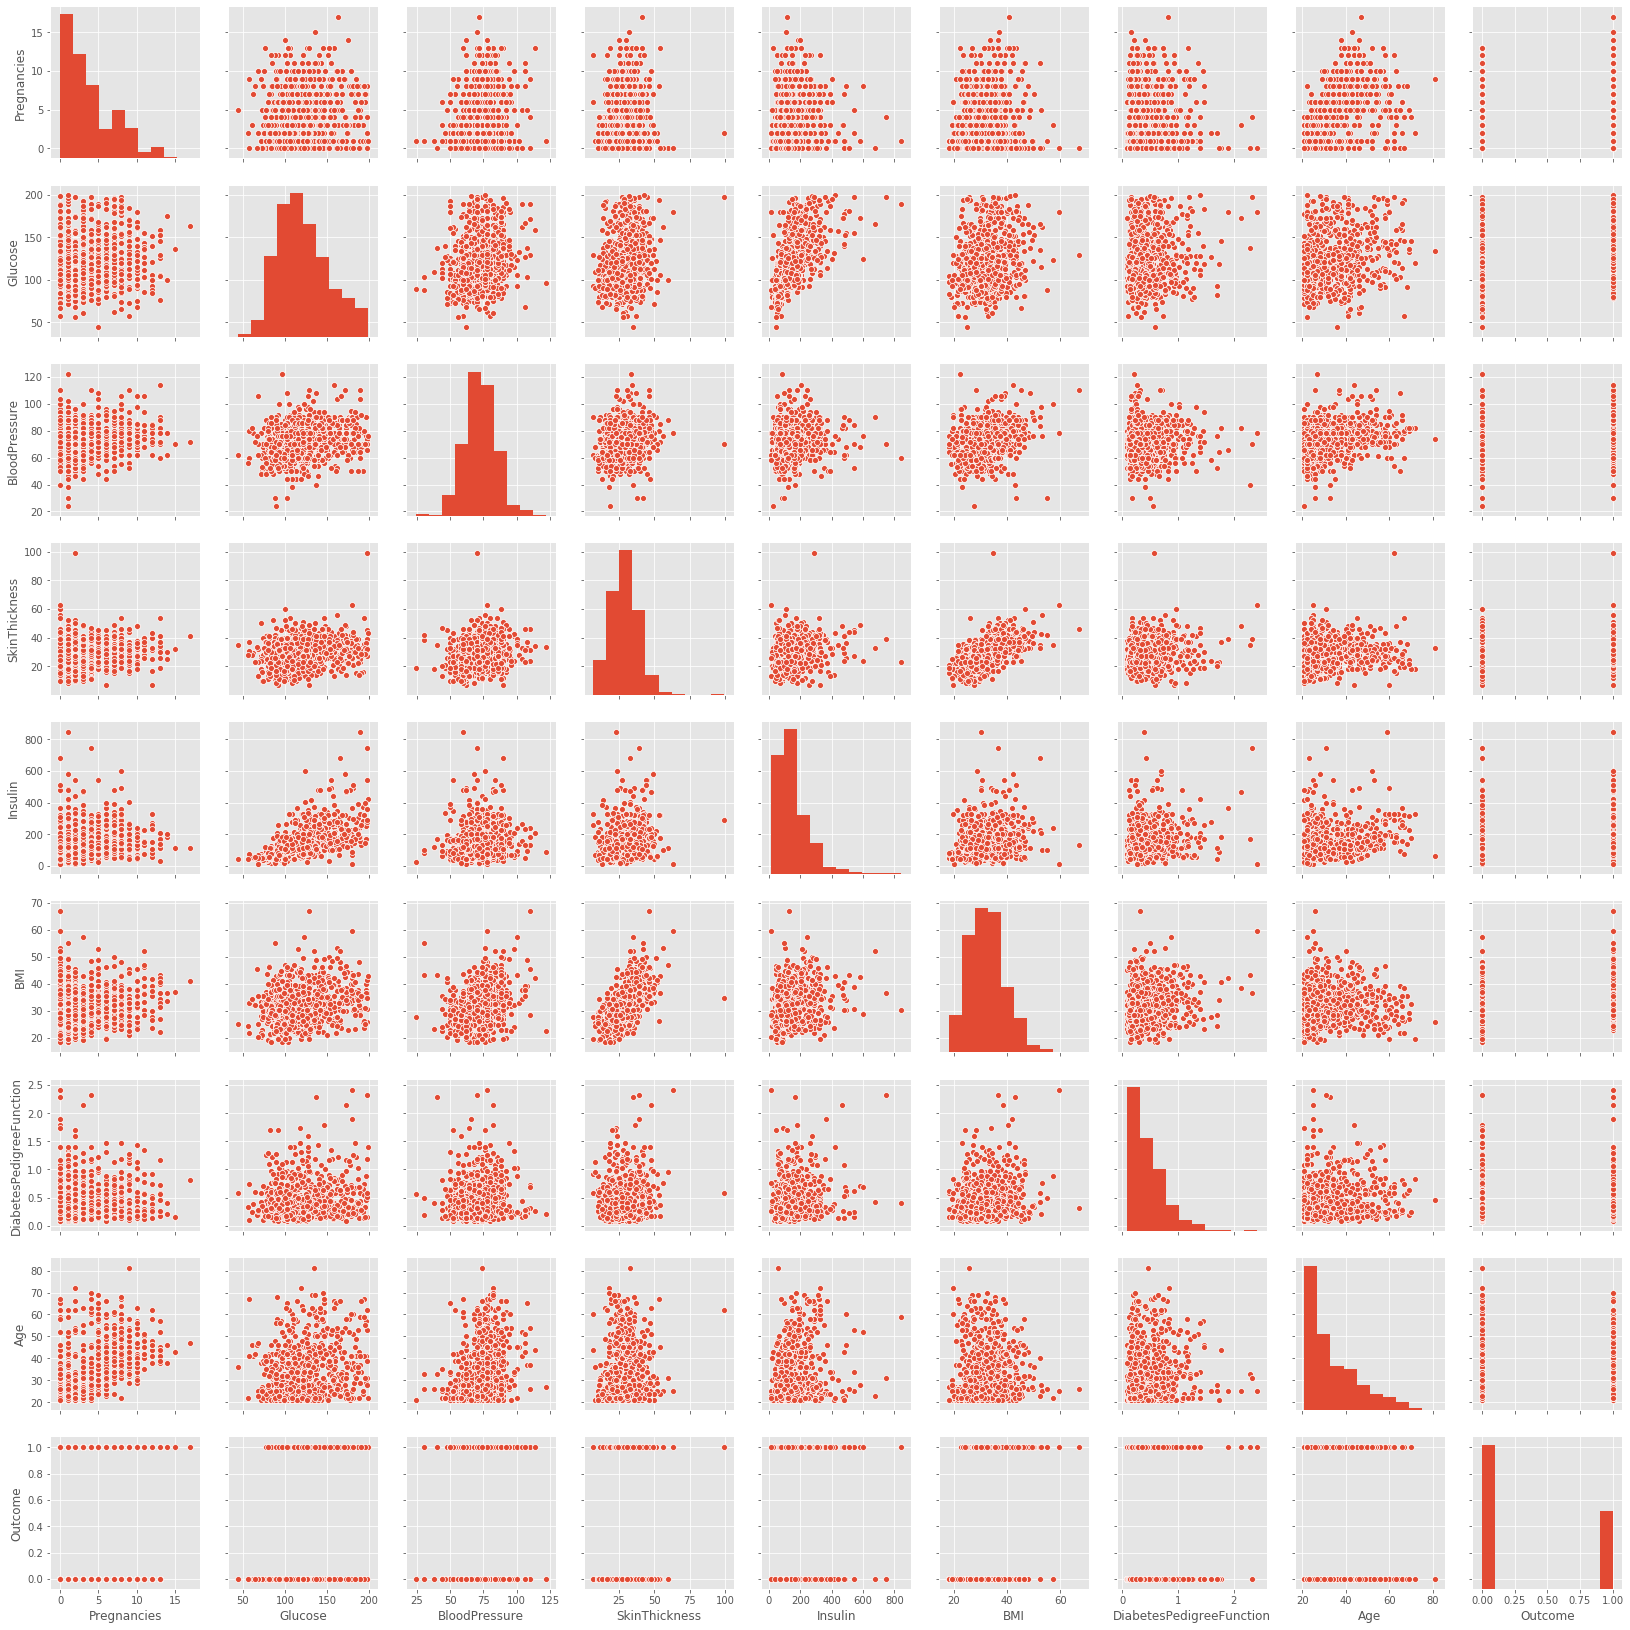

In [6]:
sns.pairplot(raw_diabetes)

In [7]:
grouped_by_outcome = raw_diabetes.groupby(raw_diabetes.iloc[:,-1]).median()
grouped_by_outcome

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Outcome,,,,,,,,,
0.0,2.0,107.0,70.0,27.000000,109.166667,30.10,0.336,27.0,0.0
1.0,4.0,140.0,74.5,32.666667,167.166667,34.25,0.449,36.0,1.0


# Visualization has and will always be key

Visualizing the data can aid the search for relationships between variables, shapes of and between catergories, and overall feel for the data.
A few visuals were already used so far, and we will continue with a:

#### correlation matrix 

and 
#### heat map

In [8]:
corr_mat_raw = raw_diabetes.corr()
corr_mat_raw

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.132429,0.214150,0.110252,0.068347,0.022613,-0.033523,0.544341,0.221898
Glucose,0.132429,1.000000,0.234484,0.238568,0.606288,0.237609,0.140091,0.271275,0.496368
BloodPressure,0.214150,0.234484,1.000000,0.224489,0.126988,0.292921,0.004352,0.336553,0.174439
SkinThickness,0.110252,0.238568,0.224489,1.000000,0.222297,0.638002,0.111949,0.143450,0.274403
Insulin,0.068347,0.606288,0.126988,0.222297,1.000000,0.241546,0.144256,0.242983,0.299445
BMI,0.022613,0.237609,0.292921,0.638002,0.241546,1.000000,0.155653,0.026585,0.312493
DiabetesPedigreeFunction,-0.033523,0.140091,0.004352,0.111949,0.144256,0.155653,1.000000,0.033561,0.173844
Age,0.544341,0.271275,0.336553,0.143450,0.242983,0.026585,0.033561,1.000000,0.238356
Outcome,0.221898,0.496368,0.174439,0.274403,0.299445,0.312493,0.173844,0.238356,1.000000


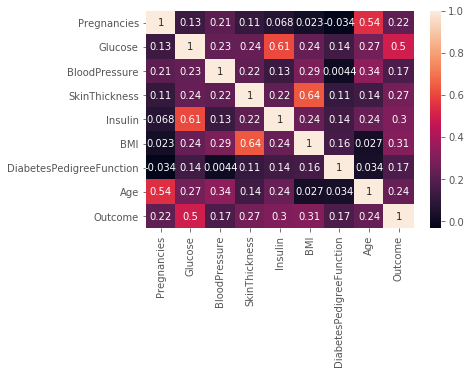

In [9]:
sns.heatmap(corr_mat_raw, annot = True)

## Data Cleaning:    
Descriptions above shows some outliers (e.g. 15 pregnancies) so lets get rid of those in our data to create more accurate predictions.
We will do this in a similar fashion to the 0 values: (1) convert them to Nan, then (2) fill them in with a k-Nearest Neighbors imputation method.

We see if the IQR scores method for detecting the outliers is appropiate by checking the number of outliers with another outlier detection technique DBSCAN (Density-Based Spatial Clustering of Applications with Noise).

We can also preserve the raw data to compare models w/ both: to see if this decision was correct.

In [10]:
#Calculate interquartile range from 75% - 25%
diabetes_q1 = raw_diabetes.quantile(0.25)
diabetes_q3 = raw_diabetes.quantile(0.75)
IQ_ranges = diabetes_q3 - diabetes_q1
IQ_ranges

Pregnancies                   5.000000
Glucose                      42.000000
BloodPressure                16.000000
SkinThickness                12.666667
Insulin                     108.000000
BMI                           9.100000
DiabetesPedigreeFunction      0.382500
Age                          17.000000
Outcome                       1.000000
dtype: float64

In [11]:
#Outliers detected with the IQR method within each feature
iqr_outlier_det = ((raw_diabetes < (diabetes_q1 - 1.5 * IQ_ranges)) | ((raw_diabetes > (diabetes_q3 + 1.5 * IQ_ranges))))
iqr_outlier_det.sum()

Pregnancies                  4
Glucose                      0
BloodPressure               14
SkinThickness                4
Insulin                     31
BMI                          8
DiabetesPedigreeFunction    29
Age                          9
Outcome                      0
dtype: int64

In [12]:
#Need to scale raw data to use in DBSCAN outlier detection
scaler = sklearn.preprocessing.MinMaxScaler(feature_range =(0, 1))

scaled_array = scaler.fit_transform(raw_diabetes)
scaled_raw_diabetes = pd.DataFrame(scaled_array)
scaled_raw_diabetes.columns = raw_diabetes.columns

In [13]:
#Outliers detection with the DBSCAN method
dbs_outliers_det = DBSCAN(eps=0.40, metric="euclidean", min_samples=5, n_jobs=-1)
dbs_liers = dbs_outliers_det.fit(scaled_raw_diabetes)

In [14]:
#13 outlier patients/rows detected
Counter(dbs_liers.labels_==-1)

Counter({False: 755, True: 13})

In [15]:
#Sticking with the IQR outlier detection method so we don't have to manipulate/remove whole rows

#Convert outliers to Nan
refined_diabetes = raw_diabetes[~iqr_outlier_det]
refined_diabetes[refined_diabetes.columns].isna().sum() #Shows sums of all the Nan values in our dataframe

Pregnancies                  4
Glucose                      0
BloodPressure               14
SkinThickness                4
Insulin                     31
BMI                          8
DiabetesPedigreeFunction    29
Age                          9
Outcome                      0
dtype: int64

In [16]:
#Same previous knn imputation script 
imputed_data = knn_imputer.fit_transform(refined_diabetes)
refined_diabetes = pd.DataFrame(data=imputed_data)

In [17]:
refined_diabetes.columns = raw_diabetes.columns #Something went weird with the column names
refined_diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.799913,3.279272,0.000,1.000000,3.000000,6.000000,13.000000
Glucose,768.0,121.563368,30.550074,44.000,99.000000,117.000000,141.000000,199.000000
BloodPressure,768.0,72.074653,11.061452,40.000,64.000000,72.000000,80.000000,104.000000
SkinThickness,768.0,28.900174,9.052674,7.000,22.333333,29.000000,35.000000,54.000000
Insulin,768.0,142.767795,74.226209,14.000,83.000000,130.666667,187.166667,349.666667
BMI,768.0,32.248828,6.472826,18.200,27.500000,32.150000,36.525000,50.000000
DiabetesPedigreeFunction,768.0,0.430014,0.245891,0.078,0.242500,0.364000,0.583750,1.191000
Age,768.0,32.970486,11.199493,21.000,24.000000,29.000000,40.250000,66.000000
Outcome,768.0,0.348958,0.476951,0.000,0.000000,0.000000,1.000000,1.000000


In [18]:
#Last manipulation is to scale the refined data so we can use it in certain machine learning algorithms 
scaler = sklearn.preprocessing.MinMaxScaler(feature_range =(0, 1))

scaled_array = scaler.fit_transform(refined_diabetes)
scaled_refined_diabetes = pd.DataFrame(scaled_array)
scaled_refined_diabetes.columns = refined_diabetes.columns

scaled_raw_diabetes.describe() #data for scaled raw and refined(no outliers) is now between 0-1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.500409,0.493290,0.240211,0.167565,0.290926,0.168179,0.204015,0.348958
std,0.198210,0.197097,0.124708,0.104134,0.121209,0.140885,0.141473,0.196004,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.354839,0.408163,0.166667,0.082933,0.190184,0.070773,0.050000,0.000000
50%,0.176471,0.470968,0.489796,0.239130,0.141827,0.285276,0.125747,0.133333,0.000000
75%,0.352941,0.625806,0.571429,0.304348,0.212740,0.376278,0.234095,0.333333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 2. Building
The original data has been prepped and ready for some fun. We can now deploy a variety of algorithms to test model predictive power upon our new datasets.

Restate the goal: predict whether or not a patient has diabetes accurately (1 : has type II diabetes, 0 : no diabetes).


### Since the goal is to predict an outcome as 1 or 0, we will use machine learning algorithms which predict one of two catergories as binary classification task.

#### We will start by creating a four sets of input (X) for each dataset we've created and their respective predictive output (y), then split each into training data (80%) and validation data (20%) to diminish the risk of under- and overfitting. 

Recap: There are  4 groups now: (1) raw, (2) refined (no outliers), (3) scaled raw, and (4) scaled refined. Time to start testing models.

We will also use stratefied k-fold cross-validation to ensure an optimal model.

In [19]:
#Create the X's

labels = raw_diabetes.columns
raw_X = raw_diabetes[labels]
refined_X = refined_diabetes[labels]
scaled_raw_X = scaled_raw_diabetes[labels]
scaled_refined_X = scaled_refined_diabetes[labels]

raw_X = raw_X.drop(['Outcome'], axis=1)
refined_X = refined_X.drop(['Outcome'], axis=1)
scaled_raw_X = scaled_raw_X.drop(['Outcome'], axis=1)
scaled_refined_X = scaled_refined_X.drop(['Outcome'], axis=1)

In [20]:
#Create the y's
raw_y = raw_diabetes['Outcome']
refined_y = refined_diabetes['Outcome']
scaled_raw_y = scaled_raw_diabetes['Outcome']
scaled_refined_y = scaled_refined_diabetes['Outcome']

# Classic way of splitting data with train_test_split.
We will split the data into a training set for the algorithm to find dependencies and then use the best-fit model from the training set on the test set. We can use simple calculations to evaluate these algorithms with confusion matrices and consequently sensativity (true positive rate) and specificity (true negative rate).

We will do this by:<br>
    (1) splitting each dataset into train and test sets, <br>
    (2) creating a function for getting a confusion matrix, <br>
    (3) creating a function for getting the sensativity and specificity, <br>
    (4) creating a function for getting the accuracy rates based on sensativity and specificity,<br>
    (5) creating all the models from the algorithms we want to test, <br>
    (6) compare the accuracy rates within algorithms to optimize them, <br>
    (7) compare the raw to refined data (which one creates a more accurate model?), <br>
    (8) and finally compare the accuracy rates across algorithms to choose the best-fitting model<br>
    
We will use several algorithms for this binary classification task: logistic regression, random forest classifier, decision tree classifier, support vector machine, and k-nearest neighbors.

In [21]:
#(1)Splitting up data in training data and validation data for each dataset, with all random state of 42 for consistency

X_rawtrain, X_rawval, y_rawtrain, y_rawval = train_test_split(raw_X,raw_y, random_state=42)
X_reftrain, X_refval, y_reftrain, y_refval = train_test_split(refined_X,refined_y, random_state=42)
X_scale_rawtrain, X_scale_rawval, y_scale_rawtrain, y_scale_rawval = train_test_split(scaled_raw_X,scaled_raw_y, random_state=42)
X_scale_reftrain, X_scale_refval, y_scale_reftrain, y_scale_refval = train_test_split(scaled_refined_X,scaled_refined_y, random_state=42)

In [22]:
#(2)Create a function for confusion matrix to true and false positives, and true and false negatives
def get_cm(model, X_train, X_pred, y_train, y_true):
    model.fit(X_train, y_train)
    preds = model.predict(X_pred)
    cmlogreg = sklearn.metrics.confusion_matrix(y_true, preds)
    return cmlogreg

In [23]:
#(3)Create function for sensativity based on confusion matrices
def get_sensespec(cm_array):
    sense = cm_array[0,0]/(cm_array[0,0]+cm_array[1,0])
    specfy = cm_array[1,1]/(cm_array[1,1]+cm_array[0,1])
    return str(round(sense*100,2)) + "% were correctly identified with diabetes and " + str(round(specfy*100,2)) + "% were correctly identified without diabetes"

In [98]:
#(4)Create function for accuracy based on specific algorithm
def get_accuracy(model, X_train, X_pred, y_train, y_true):
    model.fit(X_train, y_train)
    preds = model.predict(X_pred)
    accur = sklearn.metrics.accuracy_score(y_true, preds)
    return accur

In [73]:
#(5)Create all the models in list
model_rawlist = [
('logregmodel', LogisticRegression(random_state=42, max_iter=1000)),
('ranforest_model', RandomForestClassifier(random_state=42)),
('dtc_model', sklearn.tree.DecisionTreeClassifier(max_leaf_nodes=10, random_state=42)),
('svm_model', sklearn.svm.SVC(kernel='linear')),
('knn_model', sklearn.neighbors.KNeighborsClassifier(n_neighbors=10)),
]
    
#Example confusion matrix:
get_cm(model_list['ranforest_model'], X_rawtrain, X_rawval, y_rawtrain, y_rawval)

array([[94, 29],
       [23, 46]], dtype=int64)

### (6) Optimization of two models - bigger step then previous ones
The only models that require optimization are the decision tree classifier's max_leaf_nodes number
and the k-nearest neighbor's n_neighbors number --> starting with the decision tree classifier

In [34]:
#Need a specific functions for accuracy of decision tree model where we can pass in a max_leaf_node and neighbor numbers

def get_dtc_accuracy(max_leaf_nodes, train_X, test_X, train_y, test_Y):
    dtc_model = sklearn.tree.DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=42)
    dtc_model.fit(train_X, train_y)
    dtr_predvals = dtc_model.predict(test_X)
    accur = sklearn.metrics.accuracy_score(test_Y, dtr_predvals)
    return accur

def get_knn_accuracy(neighbor_num, train_X, test_X, train_y, test_Y):
    knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=neighbor_num)
    knn_model.fit(train_X, train_y)
    knn_predvals = knn_model.predict(test_X)
    accur = sklearn.metrics.accuracy_score(test_Y, knn_predvals)
    return accur

In [35]:
#Create two loops (raw and refined) to see what is the best tree size AND best neighbor number

candidate_nums = np.arange(2,100)

dtr_acc_scores = {leaf_size : get_dtc_accuracy(leaf_size, X_rawtrain, X_rawval, y_rawtrain, y_rawval) 
                  for leaf_size in candidate_nums}
best_tree_size = max(dtr_acc_scores, key=dtr_acc_scores.get)

#best number of leaf nodes for dtc model (raw data) is 8
best_tree_size

8

In [36]:
dtr_acc_scores = {leaf_size : get_dtc_accuracy(leaf_size, X_reftrain, X_refval, y_reftrain, y_refval) 
                  for leaf_size in candidate_nums}
best_tree_size = max(dtr_acc_scores, key=dtr_acc_scores.get)

#best number of leaf nodes for dtc model (refined data) is 2
best_tree_size

2

In [37]:
knn_acc_scores = {neigh_size : get_knn_accuracy(neigh_size, X_rawtrain, X_rawval, y_rawtrain, y_rawval) 
                  for neigh_size in candidate_nums}
best_neigh_num = max(knn_acc_scores, key=knn_acc_scores.get)

#best number of neighbors for knn model (raw data) is 54
best_neigh_num

54

In [38]:
knn_acc_scores = {neigh_size : get_knn_accuracy(neigh_size, X_reftrain, X_refval, y_reftrain, y_refval) 
                  for neigh_size in candidate_nums}
best_neigh_num = max(knn_acc_scores, key=knn_acc_scores.get)

#best number of neighbors for knn model (refined data) is 44
best_neigh_num

44

In [76]:
#update raw data model dictionary 
model_rawlist.remove(model_rawlist[2])
model_rawlist.remove(model_rawlist[3])
model_rawlist.append(('dtc_model', sklearn.tree.DecisionTreeClassifier(max_leaf_nodes=8, random_state=42)))
model_rawlist.append(('knn_model', sklearn.neighbors.KNeighborsClassifier(n_neighbors=54)))
model_rawlist

[('logregmodel',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False)),
 ('ranforest_model',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('svm_model',
  SVC(C=1.0, break_ties=False, cache_size=200, 

In [56]:
#and make a refined data model dictionary (we won't use all these, but let's have all models for sake of congruency)
model_reflist = [
('logregmodel', LogisticRegression(random_state=42, max_iter=1000)),
('ranforest_model', RandomForestClassifier(random_state=42)),
('dtc_model', sklearn.tree.DecisionTreeClassifier(max_leaf_nodes=2, random_state=42)),
('svm_model', sklearn.svm.SVC(kernel='linear')),
('knn_model', sklearn.neighbors.KNeighborsClassifier(n_neighbors=44)),
]

### (7) Step of comparing raw to refined (to see if removing outliers did us any good)

In [139]:
best_scores = []
for name,model in model_rawlist:
    cm1 = get_cm(model, X_rawtrain, X_rawval, y_rawtrain, y_rawval)
    print("Name of model: "+name)
    print("Using raw data: ")
    print("Confusion matrix for model:")
    print(cm1)
    print(get_sensespec(cm1))
    raw_accuracy = round(get_accuracy(model, X_rawtrain, X_rawval, y_rawtrain, y_rawval),ndigits=5)
    print("Total raw data accuracy: " + str(raw_accuracy))
    print()
    
    if (name=="dtc_model"):
        name,model = model_reflist[2]
    if (name=="knn_model"):
        name,model = model_reflist[4]
    cm2 = get_cm(model, X_reftrain, X_refval, y_reftrain, y_refval)
    print("Using refined data: ")
    print("Confusion matrix for model:")
    print(cm2)
    print(get_sensespec(cm2))
    ref_accuracy = round(get_accuracy(model, X_reftrain, X_refval, y_reftrain, y_refval), ndigits=5)
    print("Total refined data accuracy: " + str(ref_accuracy))
    print()
    if (raw_accuracy > ref_accuracy):
        print("-->Raw data fits "+ name +" more, as it is " + str(round(raw_accuracy-ref_accuracy, ndigits=5)) + " more accruate.")
        best_scores.append((name,raw_accuracy))
    elif (ref_accuracy > raw_accuracy):
        print("-->Refined data (outliers removed) fits "+ name +" more as it is " + str(round(ref_accuracy-raw_accuracy, ndigits=5)) + " more accurate.")
        best_scores.append((name,ref_accuracy))
    else:
        print ("Raw and refined data yield equal accuracy.")
        best_scores.append((name,raw_accuracy))
    print()
    print()

Name of model: logregmodel
Using raw data: 
Confusion matrix for model:
[[100  23]
 [ 28  41]]
78.12% were correctly identified with diabetes and 64.06% were correctly identified without diabetes
Total raw data accuracy: 0.73438

Using refined data: 
Confusion matrix for model:
[[95 28]
 [25 44]]
79.17% were correctly identified with diabetes and 61.11% were correctly identified without diabetes
Total refined data accuracy: 0.72396

-->Raw data fits logregmodel more, as it is 0.01042 more accruate.


Name of model: ranforest_model
Using raw data: 
Confusion matrix for model:
[[94 29]
 [23 46]]
80.34% were correctly identified with diabetes and 61.33% were correctly identified without diabetes
Total raw data accuracy: 0.72917

Using refined data: 
Confusion matrix for model:
[[98 25]
 [26 43]]
79.03% were correctly identified with diabetes and 63.24% were correctly identified without diabetes
Total refined data accuracy: 0.73438

-->Refined data (outliers removed) fits ranforest_model m

In [140]:
#Since the knn models for raw and refined both had equal accuracy, I choose the raw data 
#  because of the higher true negative rate
best_scores

[('logregmodel', 0.73438),
 ('ranforest_model', 0.73438),
 ('svm_model', 0.74479),
 ('dtc_model', 0.71875),
 ('knn_model', 0.73958)]

## From the above information, it looks as if the support vector machine (svm) algorithm has done the best at predicting whether one has diabetes or not. Additionally, it looks like the svm model had higher accuracy with raw data.

One could say the project is now finished, as we have fitted several supervised machine learning classifcation algorithms to two different datasets (raw and refined), cross-validated them by comparing their accuracy scores, and choose the best one - svm. However, something is not quite right. 

In the beginning, we split the data into training data and validation data with the train_test_split function. I labeled this function as the 'classic' because there is a better method to validate models. First, to explain why the train_test_split function isn't the best, the train_test_split function is only one instance of data fitting and validation. It would be better if one could iterate this function and cross-validate with each iteration. Luckily, there is cross-validation strategy called:
### k-fold stratification.
In k-fold stratification, the data is split into training and test data multiple times where a model from an algorithm can be tested. In fact, when the data is re-split, the strategy uses a different training and validation set for each iteration. This is better than the train_test_split function. So let's use k-fold stratification and see if we still get svm as the best model. 

In [166]:
raw_score_results = []
for name,model in model_rawlist:
    cross_val_results = cross_val_score(model, raw_X, raw_y, cv=5)
    score_results.append(cross_val_results)
    result_msg = "%s: %f (%f)" % (name, cross_val_results.mean(), cross_val_results.std())
    print (result_msg)

logregmodel: 0.769578 (0.023022)
ranforest_model: 0.753960 (0.027249)
svm_model: 0.776063 (0.015946)
dtc_model: 0.725329 (0.039511)
knn_model: 0.743553 (0.027496)


In [167]:
ref_score_results = []
for name,model in model_reflist:
    cross_val_results = cross_val_score(model, refined_X, refined_y, cv=5)
    score_results.append(cross_val_results)
    result_msg = "%s: %f (%f)" % (name, cross_val_results.mean(), cross_val_results.std())
    print (result_msg)

logregmodel: 0.766947 (0.022819)
ranforest_model: 0.746168 (0.030806)
dtc_model: 0.720134 (0.027718)
svm_model: 0.765648 (0.017634)
knn_model: 0.738358 (0.033175)


In [ ]:
#SVM for raw is best!

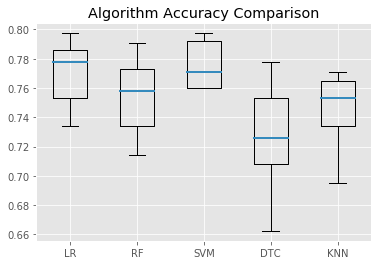

In [159]:
boxes = plt.boxplot(raw_score_results, labels=["LR", "RF", "SVM", "DTC", "KNN"], 
                    medianprops={'linewidth':2})
plt.title("Algorithm Accuracy Comparison")
plt.show()

### Make a new prediction with best model (still svm).

In [175]:
svm_model = sklearn.svm.SVC(kernel='linear')
svm_model.fit(X_rawtrain, y_rawtrain)

# New fake patient (based off 1st patient)
fake_patient = pd.DataFrame([[5, 165, 73, 32, 0, 40.3, 0.633, 60]])
patient_prediction = svm_model.predict(fake_patient)
int(patient_prediction)

#1 means predicted to have diabetes while 0 predicts patient will not.

1

# Conclusion:

In the end, the support machine vector (svc) algorithm turned out to be the best predictive algorithm with an overall accuracy of 77.6%!

Also, the refined data (no outliers) did not work better then the raw for the svm algorithm, or any other algorithm. That said there are a few notes I would like to say about the scripting above.

### Notes:

1) There is a lot of optimization to be done. First, the svm model hyperparameters can be optimized with sklearn's grid search. Secondly, the code in this notebook can be revised and cut down, removing extraneous details and lines. 

2) I included some self-made functions (such as creating a confusion matrix) to further my understand of the concept and ML predictive process.



## Bonus

ROC and AUC

This is actually leftover from when I was learning cross-validation techniques and wrote this code. However, I figured I leave it in to show that I acknowledge its existence.

In [163]:
#Graph the accuracy of logistic thresholds through AUC and ROC (split into two cells)

logregmodel = LogisticRegression(random_state=42, max_iter=1000)

# Generate a no skill prediction
ns_probas = [0 for i in range(len(y_rawval))]

# Predict probabilities
logregmodel.fit(X_rawtrain,y_rawtrain)
pred_rawvalues = logregmodel.predict_proba(X_rawval)
logregmodel.fit(X_reftrain, y_reftrain)
pred_refvalues = logregmodel.predict_proba(X_refval)

# Keep probabilities for the positive outcome only
lr_rawprobs = pred_rawvalues[:, 1]
lr_refprobs = pred_refvalues[:, 1]

# Calculate scores
ns_auc = sklearn.metrics.roc_auc_score(y_rawval, ns_probas)
lr_rawauc = sklearn.metrics.roc_auc_score(y_rawval, lr_rawprobs)
lr_refauc = sklearn.metrics.roc_auc_score(y_refval, lr_refprobs)


# Summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Raw Logistic: ROC AUC=%.3f' % (lr_rawauc))
print('Ref Logistic: ROC AUC=%.3f' % (lr_refauc))

No Skill: ROC AUC=0.500
Raw Logistic: ROC AUC=0.791
Ref Logistic: ROC AUC=0.769


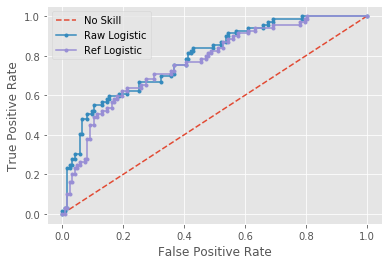

<Figure size 720x720 with 0 Axes>

In [164]:
# calculate roc curves
ns_fpr, ns_tpr, _ = sklearn.metrics.roc_curve(y_rawval, ns_probas)
lr_raw_fpr, lr_raw_tpr, _ = sklearn.metrics.roc_curve(y_rawval, lr_rawprobs)
lr_ref_fpr, lr_ref_tpr, _ = sklearn.metrics.roc_curve(y_refval, lr_refprobs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_raw_fpr, lr_raw_tpr, marker='.', label='Raw Logistic')
plt.plot(lr_ref_fpr, lr_ref_tpr, marker='.', label='Ref Logistic')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot and resize
plt.figure(figsize=(10,10))
plt.show()